# 数据预处理（数据清洗、特征工程） 
建立一个数学模型，解释所提供的电子表格中每艘帆船的上市价格，包括任何你认为有
用的预测因素。常用的数据预处理操作为：
- 数据清洗（缺失值、异常值处理）
- 特征工程（特征构造、相关性分析、分类变量进行独热编码、特征选择等）。

本jupyter文件基于2023_MCM_Problem_Y_Boats.xlsx分别对单体帆船和双体帆船进行数据预处理，处理内容包括数据清洗和特征工程，最后生成机器学习模型使用的csv文件。

## 数据清洗、特征构造
首先通过查找数据，构造了GDP、年份差值这两列新的数据特征（二手帆船的售价与GDP、帆船制造时间有关），最后将单体帆船与双体帆船分开整理，命名文件为：**单帆数据.xlsx、双帆数据.xlsx**

In [8]:
## import common
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import  r2_score,mean_absolute_error,mean_squared_error
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
if not os.path.exists('Images') or not os.path.exists('datas'):
    os.mkdir('Images')
    os.mkdir('datas')
else:
    pass

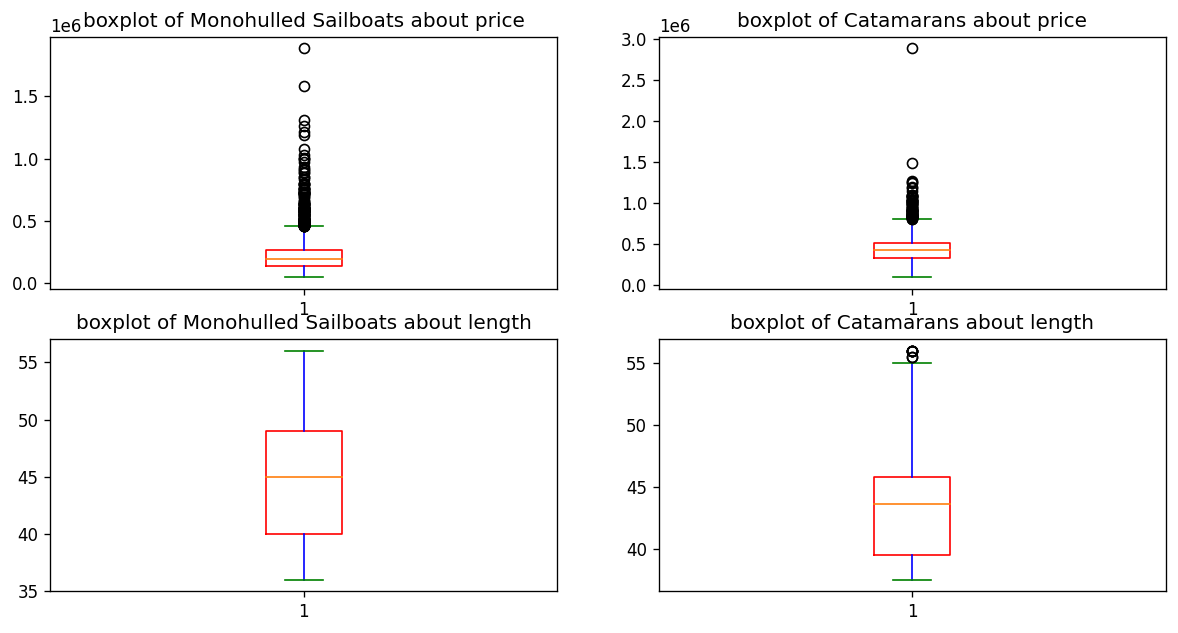

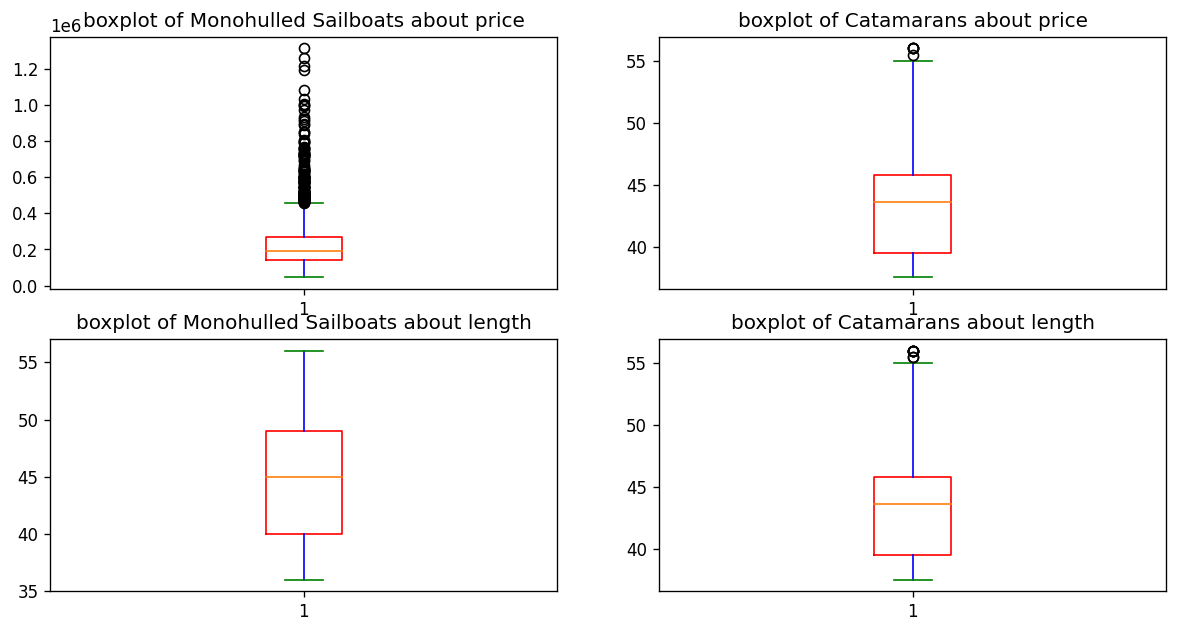

In [2]:
df_M  = pd.read_excel('datas/单帆数据.xlsx')  ##读取单体帆船数据
df_C  = pd.read_excel('datas/双帆数据.xlsx') ##读取双体帆船数据
# df_M.head(5)  ##打印单体帆船的前五行数据
# df_C.head(5)  ##打印双体帆船的前五行数据
## 查看数据的属性
# df_M.info()  ##通过info()命令发现单体帆船中country一列具有缺失值
# df_C.info()

##缺失值处理
df_M.dropna(inplace=True)
df_C.dropna(inplace=True)

##进行缺失值处理后再进行打印数据的属性
# df_M.info()  ## 单体帆船一共具有2343个样本数据
# df_C.info()  ## 双体帆船一共具有1145个样本数据

## 异常值处理，由于原始文件中只有Listing Price (USD)','Length \n(ft)'这两列的数据是连续型数据，因此需要对它们进行异常值处理
lst = ['Listing Price (USD)','Length \n(ft)']
price_M = df_M[lst[0]] ##单体帆船的价格数据
price_C = df_C[lst[0]] ##双体帆船的价格数据
length_M = df_M[lst[1]] ##单体帆船的长度数据
length_C = df_C[lst[1]] ##双体帆船的长度数据

# # 绘制箱型图,自定义箱体、须和异常值的颜色
def box_plot(data1,data2,data3,data4,filepath):
    plt.figure(figsize=(12,6),dpi=120)
    plt.subplot(2,2,1)
    plt.title('boxplot of Monohulled Sailboats about price')
    plt.boxplot(data1, boxprops=dict(color='red'), whiskerprops=dict(color='blue'), capprops=dict(color='green'), flierprops=dict(color='black', markeredgecolor='black', marker='o'))
    plt.subplot(2,2,2)
    plt.title('boxplot of Catamarans about price')
    plt.boxplot(data2, boxprops=dict(color='red'), whiskerprops=dict(color='blue'), capprops=dict(color='green'), flierprops=dict(color='black', markeredgecolor='black', marker='o'))
    plt.subplot(2,2,3)
    plt.title('boxplot of Monohulled Sailboats about length')
    plt.boxplot(data3, boxprops=dict(color='red'), whiskerprops=dict(color='blue'), capprops=dict(color='green'), flierprops=dict(color='black', markeredgecolor='black', marker='o'))
    plt.subplot(2,2,4)
    plt.title('boxplot of Catamarans about length')
    plt.boxplot(data4, boxprops=dict(color='red'), whiskerprops=dict(color='blue'), capprops=dict(color='green'), flierprops=dict(color='black', markeredgecolor='black', marker='o'))
    plt.savefig(filepath)
    plt.show()

box_plot(data1=price_M,data2=price_C,data3=length_M,data4=length_C,filepath='Images/异常值处理之前的箱型图')
## 删除异常值
#箱型图还包含一个箱体，该箱体范围从第一四分位数到第三四分位数。
# 箱体内部的线条表示中位数。箱体上下的两条线段称为“须”，用于表示数据集的范围，其中上面的“须”表示最大值，下面的“须”表示最小值。
# 超出上下“须”的点通常被认为是异常值，表示数据集中的离群点。
def out_abnormalValue(df,data,delete_nums):  ##封装一个输出异常值的函数,data是pandas类型的数据
    npdata = np.array(data)    ##将pandas类型的数据转化为数组类型
    # q1 = data.quantile(0.25) #第一四分位数（Q1）：数据集中25%的数值小于或等于该值。
    q1 = np.percentile(npdata, 25)
    # q3 = data.quantile(0.75) #第三四分位数（Q3）：数据集中75%的数值小于或等于该值。
    q3 = np.percentile(npdata,75)
    iqr = q3-q1
    lower_fence = q1 - 1.5 * iqr #1.5倍的IQR被认为是一个合理的标准，用于确定在箱型图上定义的异常值的上下边界。
    upper_fence = q3 + 1.5 * iqr
    outliers = npdata[(npdata < lower_fence) | (npdata > upper_fence)]  ##输出所有异常值
    outliers_value = outliers[np.argsort(np.abs(outliers - np.median(data)))[::-1][:delete_nums]] ##删除最异常的前delete_nums个异常值   
    # return data[~data.isin(outliers_value)] ##返回删除前delete_nums个异常值的表
    return df[~data.isin(outliers_value)]

## 根据箱型图的结果可知，单体帆船的价格异常值选择删除前十个，双体帆船的价格异常值选择删除前十个，长度值并不存在异常值，所以不需要删除
## 考虑到某些二手帆船的价格会高于一些新帆船的价格，因此可认为剩下的异常值在本题中并不算真正的异常值
df_M = out_abnormalValue(df_M,price_M,delete_nums=2)  ##去除了最异常的前10个异常值
df_C = out_abnormalValue(df_C,price_C,delete_nums=10)  ##同上
box_plot(data1=df_M[lst[0]],data2=df_C[lst[1]],data3=length_M,data4=length_C,filepath='Images/异常值处理之后的箱型图')


## 特征工程
- 首先我们发现原始数据中'Variant'这一列的数据的特征是字符串+数值型的组合，因此我们可以将该列的数据构造为Variant_char 与Variant_num两列新的特征，并且发现构造出来的新特征很明显与length这一列数据具有高度的相关性，考虑到原数据缺少数值型数据，因此我们删除掉了Variant这一列的数据，保存了length这一列的数据
- 在删除掉无关列的特征之后，我们需要对剩下的类别数据进行one-hot独热编码，以便于后续的机器学习模型使用
- 采用XGboost算法筛选重要的特征变量

In [3]:
## Warning :此单元格只能运行一次，如果想重新运行第二次需要运行上一个单元格之后再运行此单元格
''' 对单帆类别数据进行独热编码 '''
## 对Make所在列进行独热编码
Make_df_M = pd.DataFrame()
Make_df_M = pd.get_dummies(df_M['Make'],prefix='Make')
df_M = pd.concat([df_M,Make_df_M],axis=1)
df_M.drop('Make',axis = 1,inplace=True)
## 对Region所在列进行独热编码
Region_df_M = pd.DataFrame()
Region_df_M = pd.get_dummies(df_M['Geographic Region'],prefix= 'Region')
df_M = pd.concat([df_M,Region_df_M],axis=1)
df_M.drop('Geographic Region',axis = 1,inplace=True)
## 对country所在列进行独热编码
country_df_M = pd.DataFrame()
country_df_M = pd.get_dummies(df_M['Country/Region/State '],prefix='Country')
df_M = pd.concat([df_M,country_df_M],axis=1)
df_M.drop('Country/Region/State ',axis=1,inplace=True)
df_M.head()

''' 对双帆类别数据进行独热编码'''
## 对Make所在列进行独热编码
Make_df_C = pd.DataFrame()
Make_df_C = pd.get_dummies(df_C['Make'],prefix='Make')
df_C = pd.concat([df_C,Make_df_C],axis=1)
df_C.drop('Make',axis = 1,inplace=True)
## 对Region所在列进行独热编码
Region_df_C = pd.DataFrame()
Region_df_C = pd.get_dummies(df_C['Geographic Region'],prefix= 'Region')
df_C = pd.concat([df_C,Region_df_C],axis=1)
df_C.drop('Geographic Region',axis = 1,inplace=True)
## 对country所在列进行独热编码
country_df_C = pd.DataFrame()
country_df_C = pd.get_dummies(df_C['Country/Region/State '],prefix='Country')
df_C = pd.concat([df_C,country_df_C],axis=1)
df_C.drop('Country/Region/State ',axis=1,inplace=True)

## 至此，我们将类别数据全部进行了独热编码，下面需要将整理好的数据重新写入新的表格里，以便后续特征筛选使用


In [4]:
# 为了方便后面进行特征筛选，我们需要将因变量放到最后一列
y_M = df_M['Listing Price (USD)']
df_M.drop('Listing Price (USD)',axis=1,inplace=True)
df_M = pd.concat([df_M,y_M],axis=1)

y_C = df_C['Listing Price (USD)']
df_C.drop('Listing Price (USD)',axis=1,inplace=True)
df_C = pd.concat([df_C,y_C],axis=1)
# 保存编码与特征提取、数据清洗后的数据
df_M.to_csv('datas/单帆数据_清洗_编码后.csv',index=False)
df_C.to_csv('datas/双帆数据_清洗_编码后.csv',index=False)

In [5]:
# ## 使用XGboost算法对整理好的数据进行特征筛选
df_m = pd.read_csv('datas/单帆数据_清洗_编码后.csv')
df_c = pd.read_csv('datas/双帆数据_清洗_编码后.csv')
data_M = df_m.values
data_C = df_c.values
scaler = MinMaxScaler()
data_m = scaler.fit_transform(data_M)
data_c = scaler.fit_transform(data_C)
x_M = data_m[:,:-1]
y_M = data_m[:,-1]
x_C = data_c[:,:-1]
y_C = data_c[:,-1]
X_M_train,X_M_test,y_M_train,y_M_test = train_test_split(x_M,y_M,test_size=0.2,random_state=0)
X_C_train,X_C_test,y_C_train,y_C_test = train_test_split(x_C,y_C,test_size=0.2,random_state=0)

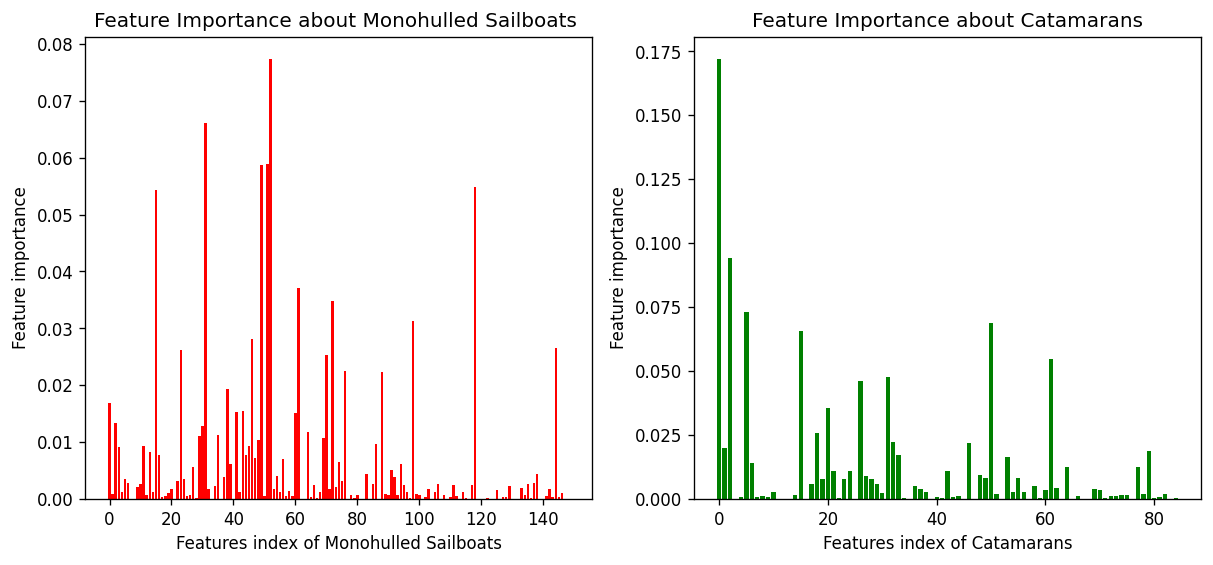

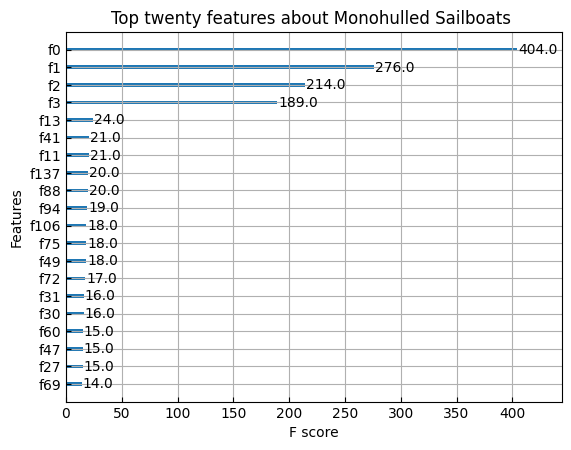

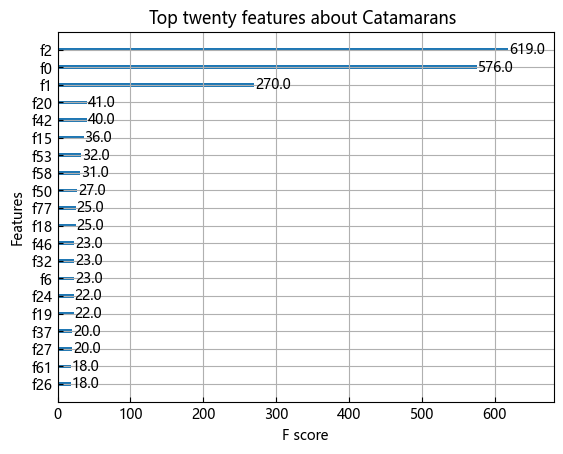

C:\Users\ndlcwx\AppData\Local\Temp\ipykernel_2684\535074005.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_M_new['Listing Price (USD)'] = data_M[:,-1]
C:\Users\ndlcwx\AppData\Local\Temp\ipykernel_2684\535074005.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_C_new['Listing Price (USD)'] = data_C[:,-1]


In [6]:
## 对单体帆船、双体帆船数据进行特征筛选（使用XGboost算法）
from xgboost import XGBRegressor
from xgboost import plot_importance
# Train original model and plot feature importance
xgb_M = XGBRegressor()
xgb_C = XGBRegressor()
xgb_M.fit(X_M_train,y_M_train)  ##训练单体帆船数据
xgb_C.fit(X_C_train,y_C_train)  ##训练双体帆船数据
plt.figure(figsize=(12, 5),dpi=120)
plt.subplot(1,2,1)
plt.bar(range(len(xgb_M.feature_importances_)), xgb_M.feature_importances_,color ='red')
plt.xlabel('Features index of Monohulled Sailboats')
plt.ylabel('Feature importance')
plt.title('Feature Importance about Monohulled Sailboats ')
plt.subplot(1,2,2)
plt.bar(range(len(xgb_C.feature_importances_)), xgb_C.feature_importances_,color = 'green')
plt.xlabel('Features index of Catamarans')
plt.ylabel('Feature importance')
plt.title('Feature Importance about Catamarans')
plt.savefig('Images/XGboost特征重要性柱状图')
plt.show()

## 这里画出特征重要性排名前二十的特征ID
plot_importance(xgb_M,max_num_features=20,title='Top twenty features about Monohulled Sailboats ')
plt.yticks([i for i in range(20)])
plt.rcParams['font.family'] = 'Microsoft YaHei'  # 设置微软雅黑字体
plt.tick_params(axis='both', direction='in')
plt.savefig('Images/XGboost算法筛选的前20个特征图_单帆.png')
plot_importance(xgb_C,max_num_features=20,title='Top twenty features about Catamarans ')
plt.yticks([i for i in range(20)])
plt.rcParams['font.family'] = 'Microsoft YaHei'  # 设置微软雅黑字体
plt.tick_params(axis='both', direction='in')
plt.savefig('Images/XGboost算法筛选的前20个特征图_双帆.png')
plt.show()

## 下面保存筛选之后的特征，单帆选取40个重要的特征变量、双帆选取20个重要特征变量
top_n1 = df_m.columns[np.argsort(xgb_M.feature_importances_)[::-1][:40]]
top_n2 = df_c.columns[np.argsort(xgb_C.feature_importances_)[::-1][:20]]
X_M_new = df_m[top_n1]
X_C_new = df_c[top_n2]
X_M_new['Listing Price (USD)'] = data_M[:,-1]
X_C_new['Listing Price (USD)'] = data_C[:,-1]
## 将筛选之后的特征写入新的csv文件
X_M_new.to_csv('datas/单帆数据_清洗_编码后_XGboost特征筛选后.csv',index=False)
X_C_new.to_csv('datas/双帆数据_清洗_编码后_XGboost特征筛选后.csv',index=False)

Spearman correlation matrix:
 [[ 1.         -0.03024504  0.00392477 -0.01460807 -0.01483672  0.00631083
   0.06803267  0.07520248  0.01334285 -0.02118593 -0.04403235 -0.0255067
  -0.00480299 -0.0127207  -0.03066659  0.03826398 -0.07431718 -0.02053233
  -0.04901341 -0.05197121  0.63487731]
 [-0.03024504  1.         -0.01614368  0.02433836 -0.06780672 -0.03706987
  -0.05921213  0.0035332  -0.00838309  0.09117147  0.10578589  0.08176861
  -0.02062986  0.04221658 -0.08478962  0.05173372  0.22361058 -0.03442002
   0.032508   -0.01275833  0.54963643]
 [ 0.00392477 -0.01614368  1.         -0.01807701 -0.02382753 -0.01908728
  -0.03556568 -0.00468482 -0.01626598 -0.06737997 -0.07999571 -0.02338534
   0.09223414 -0.00395589  0.18626131 -0.0312835  -0.01303125 -0.00614751
  -0.01417299 -0.01615506  0.06883689]
 [-0.01460807  0.02433836 -0.01807701  1.          0.03412388 -0.09756029
  -0.18178594  0.21871568 -0.07069741 -0.01891015  0.22597471 -0.11952889
   0.30338188 -0.02021965 -0.09705186 -0

<AxesSubplot:>

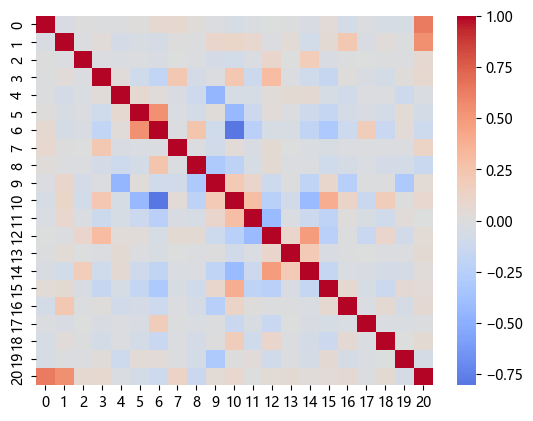

In [11]:
## 对筛选后的变量进行spearman相关性检验
# 计算多元Spearman相关系数
corr_matrix, p_value_matrix = stats.spearmanr(X_C_new)

print('Spearman correlation matrix:\n', corr_matrix)
print('p-value matrix:\n', p_value_matrix)
# 绘制热力图
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)